In [1]:
import numpy as np
import matplotlib.pyplot as pl
np.random.seed  = 112358


n_trials = 60  # How many trials to run
true_cue = 1    # 1 == Visual Cue is predictive; 2 == Audio Cue is predictive
tau = 0.9       # Probability that Visual Cue is telling the truth
free_tau = 0.77  # Model's value for tau
delta = 0.68    # Reversal probability
my_model = 1    # 1 == I think Visual Cue is predictive; 2 == I think Audio Cue is predictive
rev = np.array([[delta, 1 - delta], [1 - delta, delta]])    # Reversal probability matrix for fitting contingency switch beliefs

cues = [[('V1A1'), tau, tau], [('V2A2'), 1-tau, 1-tau], [('V1A2'), tau, 1-tau], [('V2A1'), 1-tau, tau]] # List containing the different cue pairings

# Info metric stuff
def surprise(likelihood):
    ''' Return the surprisal given a likelihood. '''
    return -1 * np.log(likelihood)


def KLD(posterior, prior):
    ''' Return their definition of the Bayesian surprise; per Wikipedia this is the expected number of bits
        of useful information we gained from our observation during the update step. '''
    KLD = 0
    for i in range(len(posterior)):
        KLD += posterior[i] * np.log2(posterior[i] / prior[i])

    return KLD

# Bayes Updating
def L(cue, model, outcome, tau=tau):
    ''' Return the probability of an outcome given a cue pairing and your belief in which of the cues is predictive.
        model == 0 => Auditory
        model == 1 => Visual '''
    if (cue == 'V1A1'):
        if model:
            if outcome:
                return tau
            else:
                return 1 - tau
        else:
            if outcome:
                return 1 - tau
            else:
                return tau

    elif (cue == 'V1A2'):
        if model:
            if outcome:
                return tau
            else:
                return 1 - tau
        else:
            if outcome:
                return tau
            else:
                return 1 - tau

    elif (cue == 'V2A1'):
        if model:
            if outcome:
                return 1 - tau
            else:
                return tau
        else:
            if outcome:
                return 1 - tau
            else:
                return tau

    elif (cue == 'V2A2'):
        if model:
            if outcome:
                return 1 - tau
            else:
                return tau
        else:
            if outcome:
                return tau
            else:
                return 1 - tau


def E(posterior, reversal_matrix=rev):
    ''' Modify the posterior distribution following normal updating with the reversal probability matrix. '''
    return np.dot(posterior, reversal_matrix)


def Z(cue, outcome, prior, tau=tau):
    ''' Return the partition function corresponding to a given cue pairing, model belief, and outcome.
        prior is a 2-item list such that sum(prior) == 1 and prior[0] is the prior that V is the true_cue. '''
    v_term = L(cue=cue, model=1, outcome=outcome, tau=tau)
    v_term *= prior[0]

    a_term = L(cue=cue, model=0, outcome=outcome, tau=tau)
    a_term *= prior[1]

    return v_term + a_term


# Simulating data sets
record = [] # List of 3-tuples containing (trial number, cue used, outcome on that trial)


def det_outcome(cue, predictive_cue_index):
    ''' Return the outcome of a trial that respects the cue contingencies. '''
    reward_threshold = cue[predictive_cue_index]
    test_value = np.random.random() # min: 0 max: 0.9999... => if we want something 50% of the time then we want 0:0.4999...

    # Case: test value is more extreme than our threshold, implying that we don't give a reward.
    if (test_value > reward_threshold):
        return 0
    # Case: test value is equal to or less than our threshold, implying that we give a reward.
    else:
        return 1


def pick_a_cue(cues):
    ''' Return one of the cue types from a list of cues as follows:
        V1A1 and V2A2 occur half the time (uniform among themselves)
        V1A2 and V2A1 occur half the time (uniform among themselves) '''
    if (np.random.random() < 0.5):
        cues = cues[:2]
    else:
        cues = cues[2:]

    cue_index = np.random.randint(0, len(cues))
    return cues[cue_index]


def switch_true_cue(curr_cue, p_switch=0.1):
    ''' Switch the true cue stochastically.'''
    if (np.random.random() < p_switch):
        return [True, 3 - curr_cue]
    else:
        return [False, curr_cue]


def sim(n_trials=n_trials, cues=cues, true_cue=true_cue, switch=0.0):
    ''' Simulate n_trials of the protocol. '''
    record = []
    for i in range(n_trials):
        this_cue = pick_a_cue(cues)
        switch_cue_info = switch_true_cue(true_cue, switch)
        true_cue = switch_cue_info[1]
        this_outcome = det_outcome(this_cue, true_cue)
        record.append((i, this_cue, true_cue, switch_cue_info[0], this_outcome))
    return record

record = sim(true_cue=2, switch=0.1)
record2 = sim(true_cue=2, switch=0.1)


# Final Piece for doing bayesian updating on the simulated data sets
def update_one_step(prior, likelihood, z, rev=False):
    ''' Return the result of a single Bayesian update step. '''
    result = (prior[0] * likelihood) / z
    result = np.array([result, 1 - result])
    if rev:
        result = E(result)
    return result


def bayes(record, free_tau=free_tau, init_prior=np.array([0.5, 0.5]), rev=False):
    ''' Optimal Bayesian updating with true parameters known. '''
    n_iter = len(record)
    posteriors = []
    surprisals = []
    KLDs = []
    my_model = 1
    for i in range(n_iter):
        if (i == 0):
            prior = init_prior
        else:
            prior = posteriors[i - 1]

        this_trial = record[i]
        this_cue = this_trial[1][0]
        this_outcome = this_trial[-1]

        likelihood = L(cue=this_cue, model=my_model, outcome=this_outcome, tau=free_tau)
        z = Z(cue=this_cue, outcome=this_outcome, prior=prior, tau=free_tau)
        posterior = update_one_step(prior, likelihood, z, rev=rev)
        posteriors.append(posterior)
        # Record the info metrics as well
        surprisal = surprise(likelihood)
        kld = KLD(posterior, prior)
        surprisals.append(surprisal)
        KLDs.append(kld)

    return {'posteriors': posteriors, 'surprisal': surprisals, 'KLD': KLDs}


# Stuff for plotting/visualization
rec1 = bayes(record, rev=False)
rec2 = bayes(record, init_prior=np.array([0.25, 0.75]), rev=False)
rec3 = bayes(record, rev=True)
rec4 = bayes(record, init_prior=np.array([0.25, 0.75]), rev=True)

x = np.arange(0, len(rec1['posteriors']), 1)

def prep_y(bayes_output, key, label=''):
    ''' Extract a part of a bayes simulation output for plotting. '''
    y = [label]
    if (key=='posteriors'):
        y = y + [a[0] for a in bayes_output['posteriors']]
    elif (key in ('surprisal', 'KLD')):
        y = y + bayes_output[key]

    return y


#y1 = ['0.5 no rev'] + [a[0] for a in rec1['posteriors']]
#y2 = ['0.25 no rev'] + [a[0] for a in rec2['posteriors']]
#y3 = ['0.5 rev'] + [a[0] for a in rec3['posteriors']]
#y4 = ['0.25 rev'] + [a[0] for a in rec4['posteriors']]

y0 = prep_y(rec1, 'posteriors', 'P(Vision is Cue)')
y1 = prep_y(rec1, 'surprisal', 'Surprisal')
y2 = prep_y(rec1, 'KLD', 'KLD')

y3 = prep_y(rec3, 'posteriors', 'P(Vision is Cue')
y4 = prep_y(rec3, 'surprisal', 'Surprisal')
y5 = prep_y(rec3, 'KLD', 'KLD')


def rec_switches(record):
    ''' Return a list of trial numbers where the true cue switched over. '''
    switch_trials = []
    for rec in record:
        if (rec[-2] == True):
            switch_trials.append(rec[0])
    return switch_trials

VL = rec_switches(record)


def show_data(y_list, vlines=[], x=x):
    ''' Quick plotting tool. '''
    for y in y_list:
        if type(y[0])==str:
            pl.plot(x, y[1:], label=y[0])
        else:
            pl.plot(x, y)
    for vline in vlines:
        pl.axvline(vline, color='black')
    pl.legend()
    ymax = 1.0
    ymin = 0.0
    for y in y_list:
        no_str_y = list(filter(lambda yi: type(yi)!=str, y))
        ymax = max(ymax, max(no_str_y))
        ymin = min(ymin, min(no_str_y))
    pl.ylim(ymin, ymax)
    pl.show()







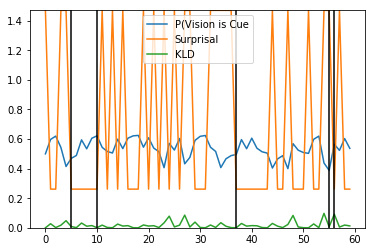

In [3]:
show_data([y3,y4,y5],VL)